# A Coevolving Scalar Opinion Graph

*By Phil Chodrow*

The purpose of this document is to run some simple tests of PC's modified coevolving scalar opinion model. This document may also serve as primary figure generation for slides and writeups. 

In [1]:
from sim.coevnet import coev, run_dynamics, er_coev
from matplotlib import pyplot as plt
from matplotlib.colors import Colormap
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.mlab as mlab
import matplotlib.colors as colors
import matplotlib.cm as cmx

from scipy.stats import norm
%matplotlib inline

In [2]:
c = [5]
k = [10]
N = [1000]

alpha = [.7]

alpha = np.repeat(alpha, 1)

control_params = {'sample'          : True,  
                  'sample_interval' : 100, 
                  'notify_end'      : True, 
                  'rand_opinions'   : True,
                  'normalize_k'     : False}

param_list = product(N, c, k, alpha)

df = pd.concat([run_dynamics(*params, **control_params) for params in param_list])

df['start'] = df.t == 0
df['run'] = np.cumsum(df.start)

df.to_csv('throughput/dynamics.csv')

Done in 529324 steps.


Approximation: the expected empirical variance $v(t)$ evolves according to the 1st order ODE

$$\dot{v}(t) \approx \frac{(1-\alpha)}{2N} \left[2\sqrt{v(t)} + 1\right] $$

which is solved numerically below, but which has an analytic solution in terms of the Lambert W function. 

Our first approximation to the mean is that the mean is just 

$$ \dot{m}(t) \approx -\frac{(1-\alpha)}{c N}\;, $$

that is, $m$ declines linearly with $t$ according to a constant that depends only on $\alpha$ and the number of edges.

Note that a pretty interesting prediction of these approximations is that, to first order, $\frac{dv}{dm}$ does not depend on $\alpha$, which is borne out in simulation for $\alpha \leq .9$ or so. Indeed, it should depend only on $c$...



In [3]:
from scipy.integrate import odeint

t = np.linspace(0, max(df.t), 10001)

def f(y, t, A, B):
    return A * np.sqrt(y) + B

def g(y, t, C, D):
    return C

A = - 1.0 * (1 - alpha[0]) / N[0]
B = .5 * (1 - alpha[0]) / N[0]
C = -1.0 * (1 - alpha[0]) / (c[0] * N[0])

v = odeint(f, df.variance[0], t, args=(A, B))
m = odeint(f, df.mean_tension[0], t, args=(C, 0))

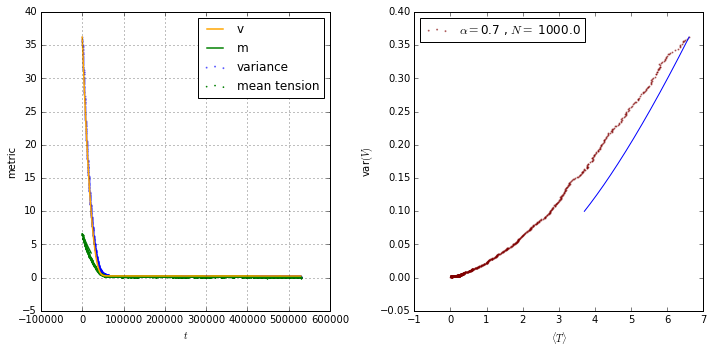

In [4]:
tee = np.arange(0, len(df.variance)) * 100

fig = plt.figure(figsize = (10, 5))
ax1 = fig.add_subplot(121)

ax1.plot(t, v, label = 'v', color = 'orange', lw = 1.5)
ax1.plot(t, m, label = 'm', color = 'green', lw = 1.5)
ax1.scatter(tee, np.array(df.variance), label = 'variance', s = 1, alpha = .5, color = 'blue')
ax1.scatter(tee, np.array(df.mean_tension), label = 'mean tension', s = .5, color = 'green')

ax1.legend(loc = 'best')
ax1.grid()
ax1.set(xlabel = r'$t$', ylabel = 'metric')



ax2 = fig.add_subplot(122)

for run in set(df.run):
    alph = df[df['run'] == run].alpha.mean()
    enn = df[df['run'] == run].N.mean()
    kay = df[df['run'] == run]['k'][0]
    ax2.scatter(df[df['run'] == run]['mean_tension'],
            df[df['run'] == run]['variance'] / kay ** 2,
            label = r'$\alpha = $' + str(alph) + ' , ' r'$N = $ ' + str(enn),
            color = cmx.jet(enn / N[0]), 
            s = 1,
            alpha = .5)
    ax2.plot(m, v / kay ** 2)

ax2.legend(loc="best")
ax2.set(ylabel = r'var$(V)$', 
       xlabel = r'$\langle T \rangle$')

plt.tight_layout()


However, this approximation is not as good as it possibly could be, so we should seek a 2nd order correction for a stronger result. The correction would potentially apply in both equations, and preferably would not lead us to moment hell. 

Note that part of the point of the 2nd-order correction would be, not just to improve the fit of the lines, but also to explain why there should be this initial transient and then quasi-steady manifold. 

Note that the approximation quality appears to decay for very small $\alpha$. There also appears to be a problem when $\alpha$ is very large, resulting in a very bad approximation for the mean in which it decays too slowly. 

Overall, we wind up quite quantitatively close on the variance, but we appear to be off by roughly a constant factor for the mean evolution. 

The mean evolution also appears to be quite sensitive to the value of $c$. 

# Simple Viz of Multiple Trajectories

The code below constructs a simple set of visualizations for multiple trajectories that allow us to get a sense for how the model behavior depends on the parameter values. The code also saves its values in a cache, potentially allowing for larger visualizations with multiple trajectories as we run it over and over. 

In [21]:
c = [5]
k = [20]
N = [1000]

alpha = [.1, .3, .5, .7, .8, .85, .9, .95, .97, .98, .99]

alpha = np.repeat(alpha, 1)

control_params = {'sample'          : True,  
                  'sample_interval' : 100, 
                  'notify_end'      : True, 
                  'rand_opinions'   : True,
                  'normalize_k'     : False}


param_list = product(N, c, k, alpha)

df = pd.concat([run_dynamics(*params, **control_params) for params in param_list])

df['start'] = df.t == 0
df['run'] = np.cumsum(df.start)

Done in 81566 steps.
Done in 46259 steps.
Done in 158177 steps.
Done in 76703 steps.
Done in 92036 steps.
Done in 100225 steps.
Done in 114631 steps.
Done in 212799 steps.
Done in 293688 steps.
Done in 374547 steps.
Done in 93694 steps.


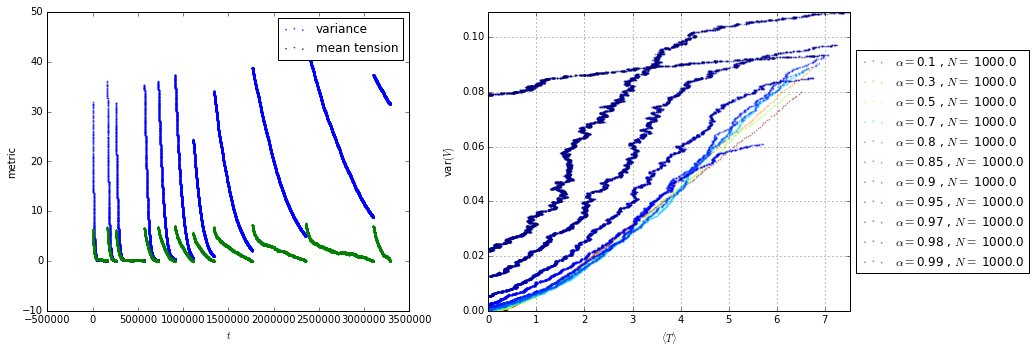

In [22]:
tee = np.arange(0, len(df.variance)) * 100

fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)

ax1.scatter(tee, np.array(df.variance), label = 'variance', s = 1, alpha = .5, color = 'blue')
ax1.scatter(tee, np.array(df.mean_tension), label = 'mean tension', s = .5, color = 'green')

ax1.legend(loc = 'best')

ax1.set(xlabel = r'$t$', ylabel = 'metric')

ax2 = fig.add_subplot(122)

alph_range = df.alpha.max() - df.alpha.min()

for run in set(df.run):
    alph = df[df['run'] == run].alpha.mean()
    enn = df[df['run'] == run].N.mean()
    kay = df[df['run'] == run]['k'][0]
    ax2.scatter(df[df['run'] == run]['mean_tension'],
            df[df['run'] == run]['variance'] / kay ** 2,
            label = r'$\alpha = $' + str(alph) + ' , ' r'$N = $ ' + str(enn),
            color = cmx.jet((df.alpha.max() - alph) / alph_range), 
            s = 1,
            alpha = .3)

# ax2.legend(loc="best")
ax2.grid()
ax2.set(ylabel = r'var$(V)$', 
       xlabel = r'$\langle T \rangle$',
       xlim = (0, df.mean_tension.max()),
       ylim = (0, (df.variance / df.k ** 2).max()))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

In [23]:
import os 

if os.path.isfile('cache.csv'):
    cache = pd.read_csv('cache.csv')
    out = pd.concate([cache, df])

else:
    out = df
    
out.to_csv('cache.csv')